<a href="https://www.kaggle.com/code/muhammadismailismail/image-captioning-project-by-ismail?scriptVersionId=128300210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#importing libraries   
import pandas as pd
import numpy as np
import cv2 
import os
import glob

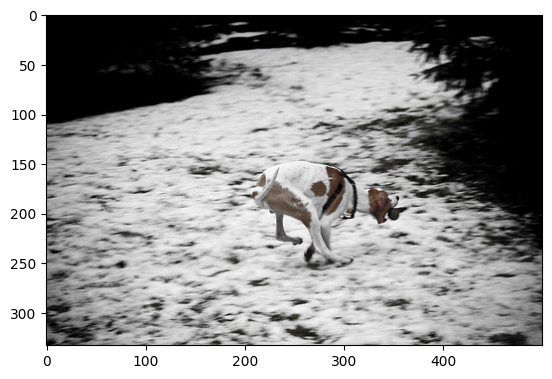

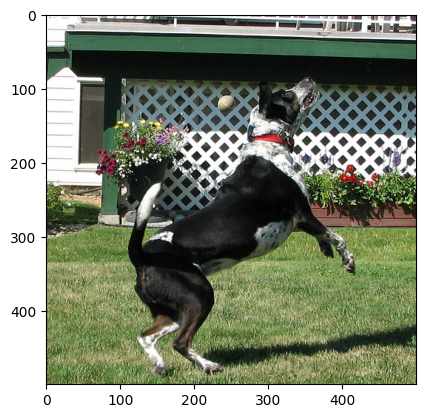

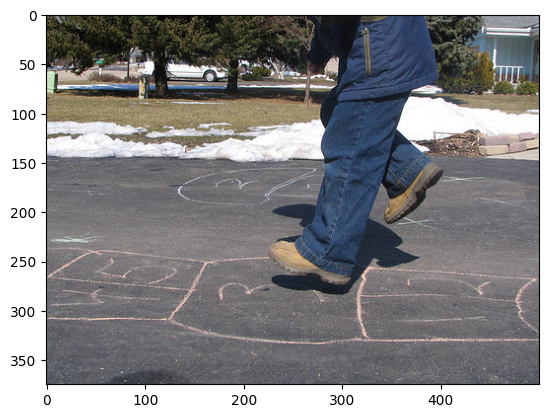

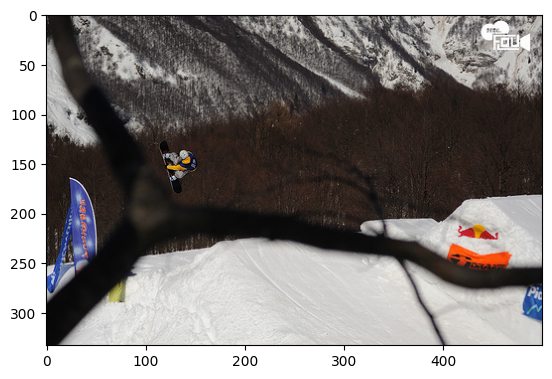

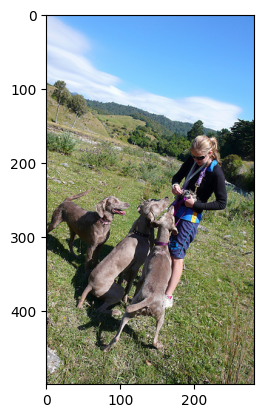

In [2]:
#importing Images
images_path="../input/flickr8k-sau/Flickr_Data/Images/"
images=glob.glob(images_path+"*.jpg")
len(images)
images[:5]
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure()
    img=cv2.imread(images[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [3]:
from tensorflow.keras.applications import ResNet50
incept_model=ResNet50(include_top=True)
#incept_model.summary()  

from keras.models import Model
last=incept_model.layers[-2].output
modele=Model(inputs = incept_model.input,outputs = last)
modele.summary()    



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


102967424/102967424 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [4]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1599:
        break
        
    elif count % 50 == 0:
        print(count)
    

1/1 [==============================] - 0s 24ms/step
50
1/1 [==============================] - 0s 26ms/step
100
1/1 [==============================] - 0s 38ms/step
150
1/1 [==============================] - 0s 22ms/step
200
1/1 [==============================] - 0s 27ms/step
250
1/1 [==============================] - 0s 22ms/step
300
1/1 [==============================] - 0s 24ms/step
350
1/1 [==============================] - 0s 25ms/step
400
1/1 [==============================] - 0s 23ms/step
450
1/1 [==============================] - 0s 24ms/step
500
1/1 [==============================] - 0s 23ms/step
550
1/1 [==============================] - 0s 23ms/step
600
1/1 [==============================] - 0s 24ms/step
650
1/1 [==============================] - 0s 23ms/step
700
1/1 [==============================] - 0s 23ms/step
750
1/1 [==============================] - 0s 23ms/step
800
1/1 [==============================] - 0s 24ms/step
850
1/1 [==============================] - 0s 24ms/st

In [5]:
len(images_features)

1600

In [6]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [7]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [8]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

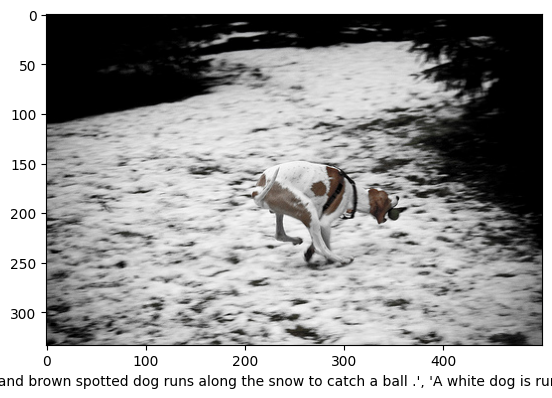

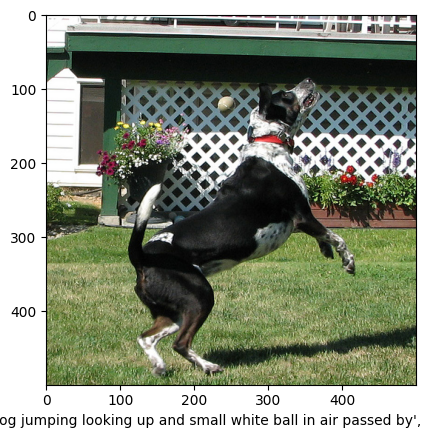

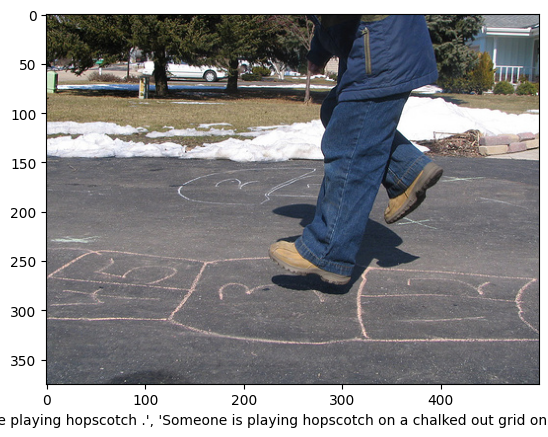

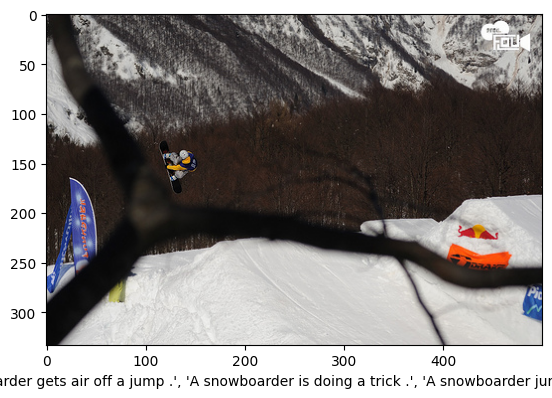

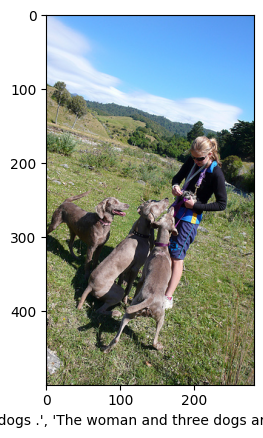

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

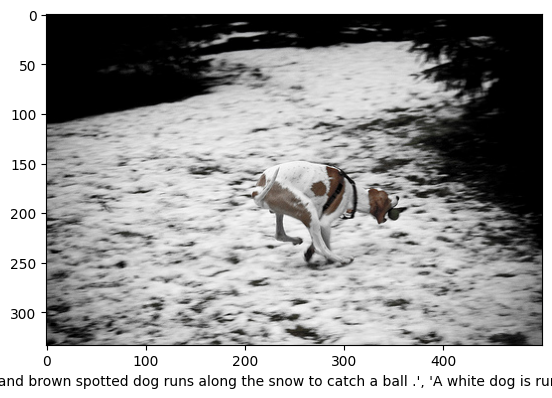

In [10]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '../input/flickr8k-sau/Flickr_Data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [11]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

In [12]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [13]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [14]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [15]:
new_dict['<OUT>'] = len(new_dict) 

In [16]:
captions_backup = captions_dict.copy()

In [17]:
captions_dict = captions_backup.copy()

In [18]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [19]:
from tensorflow.keras.utils import to_categorical
from keras.utils import pad_sequences

In [20]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 2, 11, 12, 13, 14, 15, 6, 2, 16, 17, 18]
[1, 2, 22, 4, 6, 23, 24, 25, 13, 26, 6, 9, 10, 2, 27, 28, 13, 2, 12, 29, 30, 17, 18]
[1, 2, 180, 190, 6, 2, 77, 191, 54, 77, 192, 193, 2, 53, 194, 121, 2, 41, 46, 54, 195, 196, 17, 18]
[1, 2, 180, 165, 2, 77, 205, 19, 210, 2, 215, 10, 2, 131, 54, 2, 4, 29, 23, 216, 13, 216, 206, 17, 18]
[1, 188, 4, 19, 582, 2, 583, 29, 75, 584, 585, 327, 490, 4, 184, 29, 23, 585, 13, 188, 266, 6, 23, 111, 17, 18]
[1, 23, 131, 6, 23, 77, 122, 19, 736, 2, 730, 731, 485, 2, 128, 275, 23, 131, 6, 23, 255, 393, 737, 73, 451, 151, 93, 17, 18]
[1, 23, 47, 34, 178, 49, 6, 126, 54, 27, 1095, 54, 1096, 327, 290, 6, 2, 501, 81, 331, 49, 69, 1097, 208, 2, 36, 1098, 6, 1095, 54, 2, 372, 18]
[1, 327, 188, 27, 217, 19, 35, 23, 156, 81, 490, 27, 217, 13, 2, 126, 2357, 29, 457, 307, 19, 149, 83, 2, 659, 483, 156, 327, 147, 602, 208, 2, 544, 1152, 17, 18]


In [21]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    

In [22]:
X, y_in, y_out = generator(images_features, captions_dict)

In [23]:
len(X), len(y_in), len(y_out)

(102884, 102884, 102884)

In [24]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [25]:
X.shape, y_in.shape, y_out.shape

((102884, 2048), (102884, 36), (102884, 4222))

In [26]:
X[1510]

array([0.37919554, 1.087888  , 0.        , ..., 0.04624548, 0.        ,
       0.20756893], dtype=float32)

In [27]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

**MODEL**

In [28]:
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [29]:
# Define constants
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

# Define image model
image_model = Sequential([
    Dense(embedding_size, input_shape=(2048,), activation='relu'),
    RepeatVector(max_len)
])

# Define language model
language_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len),
    LSTM(256, return_sequences=True),
    TimeDistributed(Dense(embedding_size))
])

# Concatenate image and language models
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs=out)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 36)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 36, 128)      540416      ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                            

In [30]:
# Train model
model.fit([X, y_in], y_out, batch_size=512, epochs=100)

Epoch 1/100
201/201 [==============================] - 28s 107ms/step - loss: 5.3444 - accuracy: 0.1150
Epoch 2/100
201/201 [==============================] - 15s 74ms/step - loss: 5.1750 - accuracy: 0.1189
Epoch 3/100
201/201 [==============================] - 15s 73ms/step - loss: 5.0897 - accuracy: 0.1198
Epoch 4/100
201/201 [==============================] - 14s 70ms/step - loss: 5.0106 - accuracy: 0.1191
Epoch 5/100
201/201 [==============================] - 14s 70ms/step - loss: 4.9503 - accuracy: 0.1193
Epoch 6/100
201/201 [==============================] - 14s 68ms/step - loss: 4.8953 - accuracy: 0.1185
Epoch 7/100
201/201 [==============================] - 14s 68ms/step - loss: 4.8423 - accuracy: 0.1194
Epoch 8/100
201/201 [==============================] - 14s 69ms/step - loss: 4.8057 - accuracy: 0.1195
Epoch 9/100
201/201 [==============================] - 14s 67ms/step - loss: 4.7698 - accuracy: 0.1197
Epoch 10/100
201/201 [==============================] - 14s 69ms/step - 

In [31]:
inv_dict = {v:k for k, v in new_dict.items()}

In [32]:
model.save('model.h5')

In [33]:
# Save model weights
model.save_weights('mine_model_weights.h5')

In [34]:
# Define a function to get an image
def get_image(x):
    test_img_path = images[x]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    return np.reshape(test_img, (1,224,224,3))
    
    return test_img

In [35]:
import cv2

def generate_caption(image_index):
    # Get image
    test_feature = modele.predict(get_image(image_index)).reshape(1,2048)
    if test_feature is None:
        return
    
    test_img_path = images[image_index]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Initialize caption input
    text_inp = ['startofseq']

    # Generate caption
    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = [new_dict.get(word, new_dict['UNK']) for word in text_inp]
        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        sampled_word = inv_dict[prediction]
        caption = caption + ' ' + sampled_word
        if sampled_word == 'endofseq':
            break
        text_inp.append(sampled_word)

    # Display image and caption using OpenCV
    cv2.imshow('image', test_img)
    print('Caption:', caption)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
